<h2> <b>PART 3: Model Building (Supervised and Unsupervised Techniques) </b> </h2>

<H3> Import Required Libraries</H3>


In [1]:
import pandas as pd
import pandasql as ps
import seaborn as sns
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

### Read the merged collision and weather data

In [2]:
df_cw=pd.read_csv("Joined_accident_and_weather_data.csv")
df_cw

/Users/anushkasandesara/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Crash_date,Crash_time,Borough,Zip_code,Latitude,Longitude,Location,On_street_name,Cross_street_name,Num_person_injured,...,Broader_contributing_factors,Temperature,Dew_point,Humidity,Wind_speed,Wind_gust,Pressure,Precipitation,Weather_condition,Broader_weather_condition
0,04/13/2021,21:35,BROOKLYN,11217,40.683580,-73.976170,"(40.68358, -73.97617)",NaN,NaN,1.0,...,Unspecified,51.0,40.0,66.0,9.0,0.0,30.050,0.0,Partly Cloudy,Cloudy
1,05/21/2019,22:50,BROOKLYN,11201,40.697540,-73.983120,"(40.69754, -73.98312)",GOLD STREET,CONCORD STREET,0.0,...,Driver Negligence,62.0,36.0,38.0,18.0,23.0,30.080,0.0,Mostly Cloudy,Cloudy
2,02/26/2021,14:50,BRONX,10461,40.843464,-73.836000,"(40.843464, -73.836)",NaN,NaN,0.0,...,Unspecified,45.0,17.0,33.0,8.0,0.0,30.410,0.0,Mostly Cloudy,Cloudy
3,03/31/2021,22:20,BROOKLYN,11234,40.626457,-73.918000,"(40.626457, -73.918)",RALPH AVENUE,AVENUE K,1.0,...,Driver Negligence,57.5,55.0,91.5,5.5,0.0,29.785,0.1,"Light Rain,Light Rain",Rain
4,04/06/2021,22:58,STATEN ISLAND,10312,40.526894,-74.167280,"(40.526894, -74.16728)",BARCLAY AVENUE,HYLAN BOULEVARD,7.0,...,Driver Negligence,54.0,31.0,41.0,0.0,0.0,29.940,0.0,Partly Cloudy,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226693,07/07/2012,17:35,BROOKLYN,11235,40.575802,-73.961137,"(40.5758019, -73.9611371)",BRIGHTON 6 STREET,BRIGHTWATER COURT,0.0,...,Unspecified,90.0,66.0,45.0,3.0,0.0,29.730,0.0,Mostly Cloudy,Cloudy
1226694,07/06/2012,15:09,MANHATTAN,10035,40.801235,-73.941815,"(40.8012354, -73.9418153)",EAST 119 STREET,PARK AVENUE,0.0,...,Unspecified,90.0,65.0,43.0,13.0,0.0,29.830,0.0,Fair,Fair
1226695,07/03/2012,17:30,QUEENS,11102,40.774711,-73.933386,"(40.7747112, -73.9333863)",27 AVENUE,4 STREET,2.0,...,Driver Negligence,84.0,61.0,46.0,13.0,0.0,29.820,0.0,Mostly Cloudy,Cloudy
1226696,07/01/2012,15:30,BROOKLYN,11236,40.645032,-73.919978,"(40.6450318, -73.9199775)",RALPH AVENUE,CLARENDON ROAD,0.0,...,Unspecified,96.0,63.0,33.0,18.0,24.0,29.730,0.0,Partly Cloudy,Cloudy


<h1>Modeling</h1>

### 1. Create a column for target variable by indicating whether injuries were caused (1) or not (0) due to the collision

In [3]:
df_cw=df_cw.dropna(subset=['Broader_contributing_factors']).reset_index(drop=True)
df_cw['Accident_Caused_Injuries']=df_cw['Num_person_injured'].apply(lambda x:0 if x==0 else 1 )
df_cw.columns

Index(['Crash_date', 'Crash_time', 'Borough', 'Zip_code', 'Latitude',
       'Longitude', 'Location', 'On_street_name', 'Cross_street_name',
       'Num_person_injured', 'Num_person_killed', 'Num_pedestrians_injured',
       'Num_pedestrians_killed', 'Num_cyclist_injured', 'Num_cyclist_killed',
       'Number_motorist_injured', 'Number_motorist_killed',
       'Contributing_factor_1', 'Contributing_factor_2', 'Collision_id',
       'Vehicle_type_1', 'Vehicle_type_2', 'Collision_datetime', 'Part_of_day',
       'Broader_contributing_factors', 'Temperature', 'Dew_point', 'Humidity',
       'Wind_speed', 'Wind_gust', 'Pressure', 'Precipitation',
       'Weather_condition', 'Broader_weather_condition',
       'Accident_Caused_Injuries'],
      dtype='object')

### 2. One Hot Encoding of the categorical features

In [4]:
#df_cw_contr=pd.get_dummies(df_cw['Broader_contributing_factors'])
df_cw_weather=pd.get_dummies(df_cw['Broader_weather_condition'])
df_cw_partofday=pd.get_dummies(df_cw['Part_of_day'])
df_cw_borough=pd.get_dummies(df_cw['Borough'])
df_cw_2=pd.concat([df_cw,df_cw_weather,df_cw_partofday,df_cw_borough],axis=1)
df_cw_2

,Crash_date,Crash_time,Borough,Zip_code,Latitude,Longitude,Location,On_street_name,Cross_street_name,Num_person_injured,...,Windy,Afternoon,Evening,Morning,Night,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,04/13/2021,21:35,BROOKLYN,11217,40.683580,-73.976170,"(40.68358, -73.97617)",NaN,NaN,1.0,...,0,0,0,0,1,0,1,0,0,0
1,05/21/2019,22:50,BROOKLYN,11201,40.697540,-73.983120,"(40.69754, -73.98312)",GOLD STREET,CONCORD STREET,0.0,...,0,0,0,0,1,0,1,0,0,0
2,02/26/2021,14:50,BRONX,10461,40.843464,-73.836000,"(40.843464, -73.836)",NaN,NaN,0.0,...,0,1,0,0,0,1,0,0,0,0
3,03/31/2021,22:20,BROOKLYN,11234,40.626457,-73.918000,"(40.626457, -73.918)",RALPH AVENUE,AVENUE K,1.0,...,0,0,0,0,1,0,1,0,0,0
4,04/06/2021,22:58,STATEN ISLAND,10312,40.526894,-74.167280,"(40.526894, -74.16728)",BARCLAY AVENUE,HYLAN BOULEVARD,7.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226693,07/07/2012,17:35,BROOKLYN,11235,40.575802,-73.961137,"(40.5758019, -73.9611371)",BRIGHTON 6 STREET,BRIGHTWATER COURT,0.0,...,0,0,1,0,0,0,1,0,0,0
1226694,07/06/2012,15:09,MANHATTAN,10035,40.801235,-73.941815,"(40.8012354, -73.9418153)",EAST 119 STREET,PARK AVENUE,0.0,...,0,1,0,0,0,0,0,1,0,0
1226695,07/03/2012,17:30,QUEENS,11102,40.774711,-73.933386,"(40.7747112, -73.9333863)",27 AVENUE,4 STREET,2.0,...,0,0,1,0,0,0,0,0,1,0
1226696,07/01/2012,15:30,BROOKLYN,11236,40.645032,-73.919978,"(40.6450318, -73.9199775)",RALPH AVENUE,CLARENDON ROAD,0.0,...,0,1,0,0,0,0,1,0,0,0


### 3. Selecting the features on which the model will be trained

In [5]:
# Take month/week in the future as well
features=[ 'Temperature', 'Dew_point', 'Humidity',
       'Wind_speed', 'Wind_gust', 'Pressure', 'Precipitation', 'Afternoon', 'Evening', 'Morning', 'Night','BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS',
       'STATEN ISLAND','Accident_Caused_Injuries']

df_cw_model=df_cw_2[features]
df_cw_model

,Temperature,Dew_point,Humidity,Wind_speed,Wind_gust,Pressure,Precipitation,Afternoon,Evening,Morning,Night,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Accident_Caused_Injuries
0,51.0,40.0,66.0,9.0,0.0,30.050,0.0,0,0,0,1,0,1,0,0,0,1
1,62.0,36.0,38.0,18.0,23.0,30.080,0.0,0,0,0,1,0,1,0,0,0,0
2,45.0,17.0,33.0,8.0,0.0,30.410,0.0,1,0,0,0,1,0,0,0,0,0
3,57.5,55.0,91.5,5.5,0.0,29.785,0.1,0,0,0,1,0,1,0,0,0,1
4,54.0,31.0,41.0,0.0,0.0,29.940,0.0,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226693,90.0,66.0,45.0,3.0,0.0,29.730,0.0,0,1,0,0,0,1,0,0,0,0
1226694,90.0,65.0,43.0,13.0,0.0,29.830,0.0,1,0,0,0,0,0,1,0,0,0
1226695,84.0,61.0,46.0,13.0,0.0,29.820,0.0,0,1,0,0,0,0,0,1,0,1
1226696,96.0,63.0,33.0,18.0,24.0,29.730,0.0,1,0,0,0,0,1,0,0,0,0


In [6]:
df_cw_model['Accident_Caused_Injuries'].value_counts()

0    981770
1    244928
Name: Accident_Caused_Injuries, dtype: int64

<h1>PART 3A : Unsupervised Learning </h1>

After we've gotten our data into a format which is ingestable by our computers, we ask our machines to wave it's wand and from the magic of mathematics bring out the inner structure and patterns within the data. <br>
As a pre-cursor to supervised learning, we try to implement unsupervised learning techniques such as <strong>K-means clustering</strong> and <strong>t-SNE (t-Stochastic Neighbor Embedding)</strong> to uncover hidden patterns in our dataset and visualize if some data points tend to stick together. <br>
In addition this step provides us with knowledge to make more informed decisions while selecting features for Supervised Learning in our next step.

<h3><b>K-means Clustering</h3></b>
Clustering being one of the most popular exploratory data analysis technique came as a natural choice. In this section we use Sklearn library to run K-means clustering algorithm on our dataset.

As a first step we find the SSE errors when the number of clusters range from 1 to 50 to identify the optimal number of clusters for our data.

In [8]:
from sklearn.cluster import KMeans
#Sampling a small portion while preserving the distribution
df_sample=resample(df_cw_model,n_samples=50000)
data=df_sample.to_numpy()

X = data[:,:-1]
y = data[:,-1]
#Scaling the features for use by unsupervised learning techniques
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#After scaling
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
num_cluster=50
for k in range(1, num_cluster):
    #print(k)
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)


<h4>Visualizing the SSE Errors with different number of clusters </h4>

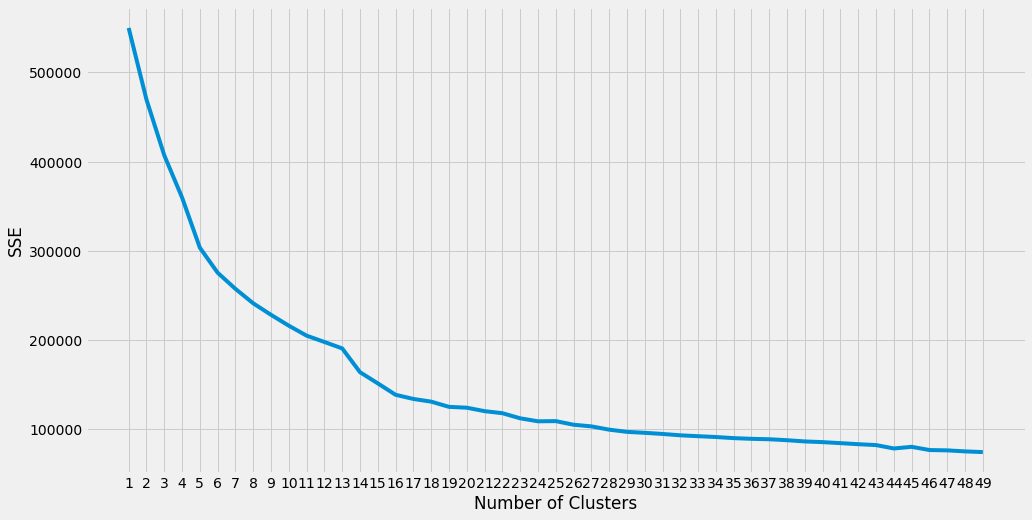

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.plot(range(1, num_cluster), sse)
plt.xticks(range(1, num_cluster))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

From the plot we see an elbow at N=21 clusters, indicating that it might be the optimal number of clusters. Furthermore as the rate of decrease of SSE errors significantly drops at N=21, we set it as our "K" for K-means clustering algorithm.

In [ ]:
num_clusters=21
kmeans = KMeans(n_clusters=num_clusters, **kmeans_kwargs)
kmeans.fit(X_scaled)
clusters=kmeans.predict(X_scaled)
df_sample['Cluster']=clusters


<ipython-input-26-1f7139b61666>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print("Correlation:")
pd.DataFrame(df_sample.corr()['Cluster'])

Correlation:


,Cluster
Temperature,-0.223644
Dew_point,-0.105643
Humidity,0.192508
Wind_speed,0.002197
Wind_gust,0.064415
Pressure,-0.007192
Precipitation,-0.109443
Afternoon,-0.222747
Evening,-0.198957
Morning,-0.093550


Arggghh, it looks like our clusters don't share a lot of corelation with our other data fields. But what if we reduce the dimensionality? 

<h3> <b> Dimensionality reduction with T-SNE ( T-Distributed Stochastic Neighbor Embedding) </h3></b>
<p>t-SNE is a popular unsupervised algorithm used for reducing dimensionality while still preserving the relationships between the data point in the low dimensional space. Therefore it fits our usecase perfectly where we need to visualize the clusters in 3D.</p>

In [ ]:
#plotX holds the values for plotting
X=df_sample
plotX = pd.DataFrame(np.array(X.sample(5000)))
plotX.columns = X.columns

### Taking 5000 samples while preserving the distribution of the data as t-SNE is very costly to run.

In [ ]:
plotX.head()

,Temperature,Dew_point,Humidity,Wind_speed,Wind_gust,Pressure,Precipitation,Afternoon,Evening,Morning,Night,Accident_Caused_Injuries,Cluster
0,72.0,55.0,55.0,10.0,0.0,30.12,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,49.0,28.0,44.0,12.0,0.0,29.98,0.0,0.0,0.0,1.0,0.0,0.0,7.0
2,73.0,67.0,81.0,20.0,26.0,30.21,0.0,0.0,0.0,1.0,0.0,1.0,18.0
3,59.0,50.0,72.0,17.0,25.0,30.21,0.0,1.0,0.0,0.0,0.0,1.0,3.0
4,76.0,65.0,69.0,13.0,20.0,29.71,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Defining t-SNE models for 1D, 2D and 3D visualizations:

In [ ]:
from sklearn.manifold import TSNE
perplexity = 50
#1D
tsne_1d = TSNE(n_components=1, perplexity=perplexity)
#2D
tsne_2d = TSNE(n_components=2, perplexity=perplexity)
#3D
tsne_3d = TSNE(n_components=3, perplexity=perplexity)

### Fitting t-SNE models:

In [ ]:
#This DataFrame holds a single dimension,built by T-SNE
TCs_1d = pd.DataFrame(tsne_1d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#This DataFrame contains two dimensions, built by T-SNE
TCs_2d = pd.DataFrame(tsne_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#And this DataFrame contains three dimensions, built by T-SNE
TCs_3d = pd.DataFrame(tsne_3d.fit_transform(plotX.drop(["Cluster"], axis=1)))

### Defining the t-SNE components for 1D, 2D, 3D visualizations:

In [ ]:
TCs_1d.columns = ["TC1_1d"]

TCs_2d.columns = ["TC1_2d","TC2_2d"]

TCs_3d.columns = ["TC1_3d","TC2_3d","TC3_3d"]

#Concatting all columns
plotX = pd.concat([plotX,TCs_1d,TCs_2d,TCs_3d], axis=1, join='inner')
#For 1D visualization
plotX["dummy"] = 0

### Creating a list of dataframes for different clusters:

In [ ]:

cluster_dict={}

for i in range(num_clusters):
    cluster_dict[i] = plotX[plotX["Cluster"] == i]


<h3>1D Plot</h3>

In [ ]:
#Traces are 0 indexed
#Eg. trace1 is for 'Cluster 0'
import random
data=[]
marker_size=2
for i in range(num_clusters):
    data.append(go.Scatter(
                    x = cluster_dict[i]["TC1_1d"],
                    y = cluster_dict[i]["dummy"],
                    mode = "markers",
                    name = f"Cluster {i}",
                    marker = dict(size=marker_size,color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)},{random.randint(0, 255)} )'),
                    text = None))


title = "Visualizing Clusters in One Dimension Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= '',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

### Analysis:- 
The above plot in 1 Dimension furnished very little information about the structure and the spacing of the clusters. So we go ahead and visualie the data via higher number of dimensions.

<h3>2D Plot</h3>

In [ ]:
data=[]
marker_size=4
for i in range(num_clusters):
    data.append(go.Scatter(
                    x = cluster_dict[i]["TC1_2d"],
                    y = cluster_dict[i]["TC2_2d"],
                    mode = "markers",
                    name = f"Cluster {i}",
                    marker = dict(size=marker_size,color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)} )'),
                    text = None))

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)


### Analysis:-
Plots in 2D show some extent of clustering. However the clusters appear to be highly spread out indicating the possible absence of natural clustering in our data. <br>To perform another level of analysis and confirm our judgement we visualize the clusters with 3 t-SNE components.

<h3>3D</h3>

In [ ]:
#Instructions for building the 3-D plot

#trace1 is for 'Cluster 0'
data=[]
marker_size=3
for i in range(num_clusters):
    data.append(go.Scatter3d(
                    x = cluster_dict[i]["TC1_3d"],
                    y = cluster_dict[i]["TC2_3d"],
                    z = cluster_dict[i]["TC3_3d"],
                    mode = "markers",
                    name = f"Cluster {i}",
                    marker = dict(size=marker_size,color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)} )'),
                    text = None))


title = "Visualizing Clusters in Three Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

### Analysis:- 
The 3D plots agree with conclusions drawn from the 2D plots. There seems to be an absence of clearly demarcated clusters calculated by the K-mean algorithm as all the clusters are interspersed amongst each other. 


Therefore we steer away from the visualization of clusters by K-means algorithm and instead check if the data clusters with respect to some other attributes:

<h5><b>Visualization of clustering with respect to collisions and different parts of day: </h5></b>

In [ ]:

pod_dict={}
pod_dict['Morning']=plotX[plotX['Morning']==1]
pod_dict['Afternoon']=plotX[plotX['Afternoon']==1]
pod_dict['Evening']=plotX[plotX['Evening']==1]
pod_dict['Night']=plotX[plotX['Night']==1]


data=[]
marker_size=3
for key in pod_dict.keys():
    #print(key)
    data.append(go.Scatter3d(
                    x = pod_dict[key]["TC1_3d"],
                    y = pod_dict[key]["TC2_3d"],
                    z = pod_dict[key]["TC3_3d"],
                    mode = "markers",
                    name = f"{key}",
                    marker = dict(size=marker_size,color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)} )'),
                    text = f"Collision occured in {key}"))


title = "Visualizing collisions during different parts of day in Three Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

<h5><b>Visualization of clustering with respect to collisions and whether injuries were caused: </h5></b>

In [ ]:

pod_dict={}
pod_dict["No Injury"]=plotX[plotX['Accident_Caused_Injuries']==0]
pod_dict["Injury"]=plotX[plotX['Accident_Caused_Injuries']==1]



data=[]
marker_size=3
for key in pod_dict.keys():
    #print(key)
    data.append(go.Scatter3d(
                    x = pod_dict[key]["TC1_3d"],
                    y = pod_dict[key]["TC2_3d"],
                    z = pod_dict[key]["TC3_3d"],
                    mode = "markers",
                    name = f"{key}",
                    marker = dict(size=marker_size,color = f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)} )'),
                    text = f"Injury Caused : {key}"))


title = "Visualizing collisions and whether they caused injuries in Three Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

While unsupervised learning techniques such as t-SNE are used in a wide variety of applications, they have their limitations too. From the visualizations we don't discern any noticeable clusters or structure in the underlying data with respect to different attributes. <br>We end our journey with unsupervised learning techniques at this point and foray into the territory of <strong>Supervised Learning.</strong>

<h1><b> PART 3B: Supervised Learning </h1></b>
<h3> Model to :- Predict collision will cause injuries or not </h3>

So, the end goal of decreasing the collisions and its effects is to make sure that least number of people are injured from it. For model building stage we decided to classify that whether our model will be able to predict that the collision will lead to injury or not. Before directly building model we started with certain steps to make the data model ready like one-hot encoding and we also performed PCA before building the models for dimensionality reduction

### Convert the data to numpy for modeling

In [7]:
data=df_cw_model.to_numpy()

###  Split the features and target variable from the data, where target variable is the feature indicating whether the collision caused injuries or not

In [8]:
X=data[:,:-1]
y=data[:,-1]

### Splitting the data into train and test for modeling

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###  Carrying out Principal component analysis
To reduce the high number of correlated features to lower number of uncorrelated features

Text(0.5, 0, 'Number of components')

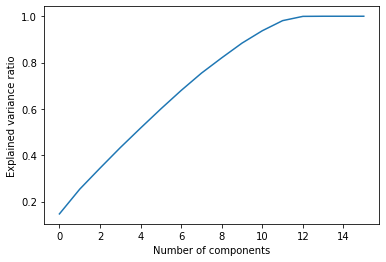

In [10]:
# scaling
# find num components to use
pca = PCA()
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)
pc = pca.fit(X_scale)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of components')

In [11]:
pca = PCA(n_components=12)
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
X_train = pca.fit_transform(X_train_pca)
X_test = pca.transform(X_test_scale)

## Model1:- Logistic Regresssion
Training the logistic regression model on the training data with elastic net regularization


In [14]:
lr_model = LogisticRegression(penalty='elasticnet', solver = 'saga', l1_ratio = 0.5)
lr_model.fit(X_train, y_train)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

Predicting the test data on the trained logistic regression model

In [15]:
y_pred = lr_model.predict(X_test)
# print(classification_report(y_test,y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average = 'weighted', zero_division=1))
print('Recall:', recall_score(y_test, y_pred, average = 'weighted'))
print('F Score:', f1_score(y_test, y_pred, average = 'weighted'))



Accuracy: 0.7998940246188962
Precision: 0.8399364260021192
Recall: 0.7998940246188962
F Score: 0.7109645811024802


## Model2:- Random Forest - Ensemble of Decision Trees


Random Forest is an ensemble of Decision Trees. The 'forest' generated by the random forest algorithm is trained through bagging or bootstrap aggregating. Bagging is an ensemble meta-algorithm that improves the accuracy of machine learning algorithms.

Training the Random forest model on the training data with GridSearch CV to select the best hyperparameters

In [62]:
rfc=RandomForestClassifier(random_state=42)
param_grid={
    'n_estimators' : [10,50,100,200],
    'max_features' : ['auto', 'sqrt'],
    'max_depth' : [4,5,6],
    'criterion' : ['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print('Best Parameters : ', CV_rfc.best_params_)

Best Parameters :  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10}


Predicting the test data on the trained random forest model

In [55]:
#y_pred1 = rfc.predict(X_test)
y_pred1 = CV_rfc.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred1))
print('Precision:', precision_score(y_test, y_pred1, average = 'weighted', zero_division=1))
print('Recall:', recall_score(y_test, y_pred1, average = 'weighted'))
print('F Score:', f1_score(y_test, y_pred1, average = 'weighted'))

Accuracy: 0.7998940246188962
Precision: 0.8399364260021192
Recall: 0.7998940246188962
F Score: 0.7109645811024802


## Model3:- Stacked Model



The benefit of stacking is that it can harness the capabilities of a range of well-performing models on a classification or regression task and make predictions that have better performance than any single model in the ensemble. It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms.


Stacking various models like <b>Random Forest, KNeighber Classifier and Decision Trees<b> with final estimator as Logistic Regression


In [16]:
# Create Base Learners
base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                 ('rf_2', KNeighborsClassifier(n_neighbors=5)), 
                ('rf_3', DecisionTreeClassifier(max_depth= 8, criterion = 'entropy', min_samples_split= 5))
                ]

# Initialize Stacking Classifier with the Meta Learner
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf_1',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('rf_2', KNeighborsClassifier()),
                               ('rf_3',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=8,
                                                       min_samples_split=5))],
                   final_estimator=LogisticRegression())

In [17]:
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average = 'weighted', zero_division=1))
print('Recall:', recall_score(y_test, y_pred, average = 'weighted'))
print('F Score:', f1_score(y_test, y_pred, average = 'weighted'))

Accuracy: 0.7998586994918616
Precision: 0.7178621990028458
Recall: 0.7998586994918616
F Score: 0.7110658554346954


<AxesSubplot:>

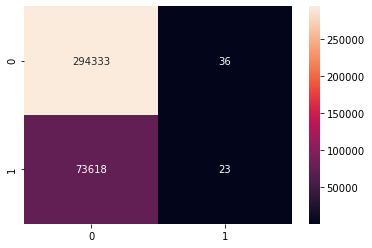

In [18]:
cf= confusion_matrix(y_test, y_pred)
#print('confusion_matrix', cf)
sns.heatmap(cf, annot=True, fmt='g')

### Analysis
We observed that although the accuracy was coming moderate enough the training data was imbalanced and was heavily biased towards 0. To overcome this issue we considered implementing **Undersampling** as taught in lectures.

## Building Models after Sampling the Data

### Undersampling -  
It is a technique implemeneted to balance the training data where it remove examples from the training dataset that belong to the majority class in order to better balance the class distribution.
    

In [12]:
# Separate majority and minority classes
df_model=df_cw_model
df_majority = df_model[df_model['Accident_Caused_Injuries']==0]
df_minority = df_model[df_model['Accident_Caused_Injuries']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=df_minority.shape[0])
# Combine minority class with downsampled majority class
df_up_down_sampled = pd.concat([df_majority_downsampled, df_minority])

### 1. Convert the data to numpy for modeling

In [13]:
data=df_up_down_sampled.to_numpy()

### 2. Split the features and target variable from the data, where target variable is the feature indicating whether the collision caused injuries or not

In [14]:
X=data[:,:-1]
y=data[:,-1]

### 3. Splitting the data into train and test for modeling

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 4. Carrying out Principal component analysis 


Text(0.5, 0, 'Number of components')

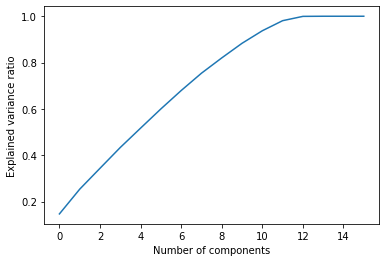

In [16]:
# scaling
# find num components to use
pca = PCA()
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)
pc = pca.fit(X_scale)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of components')

In [17]:
pca = PCA(n_components=12)
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
X_train = pca.fit_transform(X_train_pca)
X_test = pca.transform(X_test_scale)

## Model1: Logistic Regression

Training the logistic regression model on the training data with elastic net regularization

In [27]:
lr_model = LogisticRegression(penalty='elasticnet', solver = 'saga', l1_ratio = 0.5)
lr_model.fit(X_train, y_train)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

Predicting the test data on the trained logistic regression model

In [28]:
y_pred = lr_model.predict(X_test)
# print(classification_report(y_test,y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average = 'weighted', zero_division=1))
print('Recall:', recall_score(y_test, y_pred, average = 'weighted'))
print('F Score:', f1_score(y_test, y_pred, average = 'weighted'))


Accuracy: 0.5472825384296086
Precision: 0.547281531692114
Recall: 0.5472825384296086
F Score: 0.5472582880427533


## Model2: Random Forest

Training the Random forest model on the training data with GridSearch CV to select the best hyperparameters

In [18]:
rfc=RandomForestClassifier(random_state=42)
param_grid={
    'n_estimators' : [10,50,100,200],
    'max_features' : ['auto', 'sqrt'],
    'max_depth' : [4,5,6],
    'criterion' : ['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print('Best Parameters : ', CV_rfc.best_params_)

Best Parameters :  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10}


Predicting the test data on the trained random forest model

In [19]:
y_pred1= rfc.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred1))
print('Precision:', precision_score(y_test, y_pred1, average = 'weighted', zero_division=1))
print('Recall:', recall_score(y_test, y_pred1, average = 'weighted'))
print('F Score:', f1_score(y_test, y_pred1, average = 'weighted'))

Accuracy: 0.5411514932939567
Precision: 0.5435332034173598
Recall: 0.5411514932939567
F Score: 0.5353006768390053


## Model3: Stacked Model (Random Forest, KNeighbours, Decision Tree)

In [36]:
# Create Base Learners
base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42, max_depth = 15)),
                 ('rf_2', KNeighborsClassifier(n_neighbors=5)), 
                ('rf_3', DecisionTreeClassifier(max_depth= 8, criterion = 'entropy', min_samples_split= 5))
                ]

# Initialize Stacking Classifier with the Meta Learner
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf_1',
                                RandomForestClassifier(max_depth=15,
                                                       n_estimators=10,
                                                       random_state=42)),
                               ('rf_2', KNeighborsClassifier()),
                               ('rf_3',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=8,
                                                       min_samples_split=5))],
                   final_estimator=LogisticRegression())

In [37]:
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average = 'weighted', zero_division=1))
print('Recall:', recall_score(y_test, y_pred, average = 'weighted'))
print('F Score:', f1_score(y_test, y_pred, average = 'weighted'))

Accuracy: 0.5472417101601149
Precision: 0.5472888729523457
Recall: 0.5472417101601149
F Score: 0.5471794815115117


<AxesSubplot:>

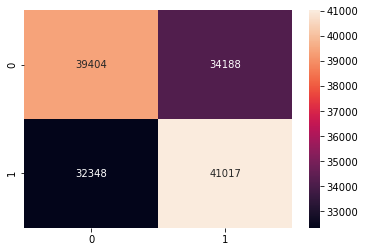

In [39]:
cf= confusion_matrix(y_test, y_pred)
#print('confusion_matrix', cf)
sns.heatmap(cf, annot=True, fmt='g')

### Analysis
After performing modeling on the downsampled data we observed that the accuracy dropped. We learnt here that instead of just focusing on the accuracy metrics for evaluating the classifier the whole data as well as its analysis needs to be taken into consideration to built bias-free and reliable models.

## Conclusion

New York is sometimes called the biggest collection of villages in the world. This is the reason why this project and the datasets caught our attention. 
A city that is known for its hustle and bustle also inevitably leads to collisions. 
With this project we embarked on a journey to uncover the patterns behind these collisions and the factors that might contribute to them. Ultimately we wanted to propose a solution which could help in reducing the number of accidents by suggesting preventive measures.

We started off with the project by collecting the collision data from [Motor Vehicle Collisions - Crashes | NYC Open Data](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) and scraping weather information from [Weather Underground](https://www.wunderground.com/). This enabled us to get an overview of the weather conditions at the time of the collision and whether they had an effect in any way.

Next up, the data was wrangled and pre-processed to deal with null values, duplicates and remove columns not offering much information.
After getting the data into a clean, easy to use format various informative visualizations were made using the data. Some of the examples include Bar Charts for showing the number of collisions with respect to the contributing factors and the different weather conditions, borough wise spread of the collisions, interactive line charts for visualizing how the time of the day had an effect on the number of collisions, 3D movable geo plots for visualizing the collision density on each street in the city and many more.

We derived several useful insights from these visualizations like:
1. Motorists were most likely to be involved in accidents
2.  Brooklyn leaded the charts in terms of number of collisions
3. Driver distractions was the leading cause of collisions
4.  More than 60% of the accidents occurred when the weather was cloudy
5. Across all the boroughs more collisions occurred on the weekdays than the weekend and that too  between 8AM and 5PM

We believe that we were able to uncover many important facts and patterns about the collisions in NYC which will assist in putting preventive measures in place and lead to safer roads.

After visualizations and EDA we proceeded on to modeling the dataset with Unsupervised and Supervised learning techniques to be able to draw predictions on whether given the weather conditions and time of the day, are the accidents likely to be severe or not. In other words, whether the accident will result in injuries. 

We trained the Supervised learning models on the training data. Models used were Logistic Regression model, Random Forest model and Stacking with K-Nearest Neighbor, Decision Tree and Logistic Regression model. Later these trained models were used to make predictions on the test data with an accuracy of around 80%. The dataset had imbalanced labels so we also downsampled our data inorder to attain equal number of 0’s and 1’s in the target variable. On training and predicting the models on this downsampled data, we got an accuracy of around 54%.

With the conclusion of modeling, we were able to build a classifier which can help the authorities put precautionary measures in place to prevent collisions from happening by putting speed, vehicle size restrictions etc. when the likelihood of severe collisions is more.



## Future Scope


In this project, we did not have time series geospatial information regarding normal traffic activity. This data can prove to be very useful for charting out routes to avoid collision prone areas. Our future efforts can be directed to obtaining this information and using it to build a guidance system for the average New Yorker for safer road journeys. 

In addition, more information about the people involved in the collision can be used by the authorities to improve their process of issuing driver licenses and changing driver tests.


## Acknowledgments


<b>Our TA, Tashweena Heeramun who constantly provided us with support and guidance.
   Prof. Zachary Ives for providing us with the concepts we needed to be confident enough to explore different areas in Big Data Analytics to get the best out of this course and project.</b>
